# Решение тестового задания
    Для того, чтобы определить, в какой день были обычные результаты, а в какой необычные постороим кривую, которая описывается полиномом с помощью метода наименьших квадратов. Для определения лучшей степени полинома посторим несколько графиков разных степеней. Также построим границы, с помощью которых можно ответить на вопрос, был ли обычный день или нет. Границы будут отличаться от изначально построенной прямой только свободным многочленом. В таком случае будет зависимость между периодоми и шагами, так как в какой-то момент жизни пользователь может ходить меньше или больше другого периода. 

Подключаем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/query_result.csv")
df.head()

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
0,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2019-05-05T12:39:59+03:00,2166,1.0
1,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2019-05-05T14:12:51+03:00,2166,34.0
2,2019-05-05T12:07:42+03:00,2019-05-05T15:07:42+03:00,10800,2019-05-05T12:07:39+03:00,2019-05-05T15:07:39+03:00,2166,1.0
3,2019-05-05T13:04:05+03:00,2019-05-05T16:04:05+03:00,10800,2019-05-05T13:04:02+03:00,2019-05-05T16:04:02+03:00,2166,3.0
4,2019-05-05T13:18:18+03:00,2019-05-05T16:18:18+03:00,10800,2019-05-05T13:18:13+03:00,2019-05-05T16:18:13+03:00,2166,6.0


Выберем столбцы "Time End" и "Value". Изменим тип данных столбца времени. 

In [5]:
x_labels = ['Time End', 'Value']
X = df.loc[:, x_labels]
end = X['Time End'].values
end = pd.to_datetime(end)
X['Time End'] = end

По дню и мясяцу определим, сколько было шагов у пользователя за определённый день. 

In [6]:
month = end.month
month = month.unique()
array = []
for i in month:
    date_month = X[pd.to_datetime(X['Time End'].values).month == i]
    days = date_month['Time End'].values
    days = pd.to_datetime(days)
    days = days.day
    days = days.unique()
    for j in days:
        sum = date_month.loc[pd.to_datetime(date_month['Time End'].values).day == j, 'Value'].sum()
        array.append([sum,j,i])

Отсортируем данные по дню и месяцу.

In [7]:
array = sorted(array, key=lambda x: (x[2], x[1]))

Найдём последний дни месяца и с помощью них объединим все дни в одну группу.

In [8]:
def foo(arr):
        mx = defaultdict(int)
        for a in arr:
                mx[a[2]] = (max(mx[a[2]], a[1]))
        return mx

dict_max = dict(foo(array))
array_dict = list(dict_max.values())

stop = array[0][2]
all_days = []
n = 0
difference = array_dict[n]
n = n + 1
for i in array:
        if i[2] == stop: all_days.append(i[1])
        else: 
                all_days.append(i[1] + difference)
                if(i[1] == array_dict[n]):
                        difference = difference + array_dict[n]
                        n = n + 1

Построим полученные точки на плоскоти и аппроксимирающую прямую при разных степенях многочлена.

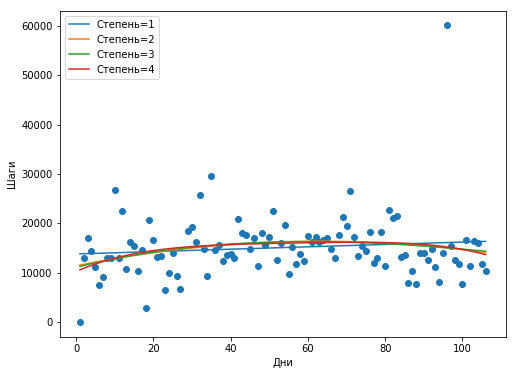

In [10]:
steps = []
for i in array:
        steps.append(i[0])

X = all_days
y = steps
plt.figure(figsize=(8, 6))
plt.xlabel("Дни")
plt.ylabel("Шаги")
plt.scatter(X, y)

legend = [] 
for i in range(1, 5):
    func = np.poly1d(np.polyfit(X, y, i, full=True)[0])
    x_points = np.linspace(min(X), max(X), 1000)
    plt.plot(x_points, func(x_points)) 
    legend.append("Степень=%i" % func.order)   

plt.legend(legend, loc="upper left")
plt.show()
plt.close()

Из графика видно, что кривые по 2, 3 и 4 степеням почти совпадают. Оставим 2-ую степень, по которой будут строяться границы. Разделим на 70% данных, которые будут находиться между границами. Эти данные отвечают за то, что день обычный.

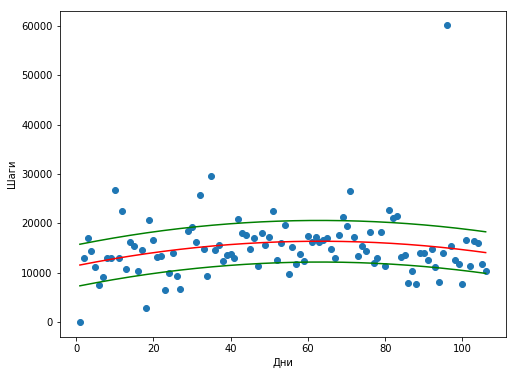

In [11]:
def delta_find(x,y1,y2):
        delta = 0
        accuracy = 0.7
        my_accuracy = 0
    
        while my_accuracy < accuracy :
            counter = 0    
            y_up = y1 + delta
            y_down = y1 - delta
            for i in range(len(y2)):
                if y2[i]>=y_down[i] and y2[i]<=y_up[i]:
                    counter+=1 
            delta+=0.01       
            my_accuracy = counter/(len(y2))
        return(delta)
    
func = np.poly1d(np.polyfit(X, y, 2, full=True)[0])

delta = delta_find(X, func(X), y) 

stat = []
for i,j in zip(X, y):
        if  (func(i) + delta > j) and (func(i)-delta < j):
                stat.append([i, 'Usual day'])
        else: stat.append([i, 'Unusual day'])

x_points = np.linspace(min(X), max(X), 1000)

plt.figure(figsize=(8, 6))
plt.xlabel("Дни")
plt.ylabel("Шаги")
plt.scatter(X, y)
plt.plot(x_points, func(x_points),'r')
plt.plot(x_points, func(x_points)+delta,'g')
plt.plot(x_points, func(x_points)-delta,'g')
plt.show()
plt.close()

Теперь для последовательности дней имеем информацию о том, какой он был.

In [15]:
stat

[[1, 'Unusual day'],
 [2, 'Usual day'],
 [3, 'Unusual day'],
 [4, 'Usual day'],
 [5, 'Usual day'],
 [6, 'Unusual day'],
 [7, 'Usual day'],
 [8, 'Usual day'],
 [9, 'Usual day'],
 [10, 'Unusual day'],
 [11, 'Usual day'],
 [12, 'Unusual day'],
 [13, 'Usual day'],
 [14, 'Usual day'],
 [15, 'Usual day'],
 [16, 'Usual day'],
 [17, 'Usual day'],
 [18, 'Unusual day'],
 [19, 'Unusual day'],
 [20, 'Usual day'],
 [21, 'Usual day'],
 [22, 'Usual day'],
 [23, 'Unusual day'],
 [24, 'Unusual day'],
 [25, 'Usual day'],
 [26, 'Unusual day'],
 [27, 'Unusual day'],
 [29, 'Usual day'],
 [30, 'Usual day'],
 [31, 'Usual day'],
 [32, 'Unusual day'],
 [33, 'Usual day'],
 [34, 'Unusual day'],
 [35, 'Unusual day'],
 [36, 'Usual day'],
 [37, 'Usual day'],
 [38, 'Usual day'],
 [39, 'Usual day'],
 [40, 'Usual day'],
 [41, 'Usual day'],
 [42, 'Unusual day'],
 [43, 'Usual day'],
 [44, 'Usual day'],
 [45, 'Usual day'],
 [46, 'Usual day'],
 [47, 'Unusual day'],
 [48, 'Usual day'],
 [49, 'Usual day'],
 [50, 'Usual day'